# Data Cleaning
For regression, we need to filter out certain schools who do not fit our analysis (like a certain amount of Black/white students or school suspensions)

### Standard Python and R imports

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%R

# My commonly used R imports

require('tidyverse')
require('broom')
require('GGally')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: tidyverse
Loading required package: broom
Loading required package: GGally
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


## Read in data

In [3]:
%%R
library(data.table)

# Import data with R
df <- fread('../data/final_data.csv')
lunch_program <- fread('../data/ccd_sch_033_2122_l_1a_071722/ccd_sch_033_2122_l_1a_071722.csv') 

data.table 1.17.0 using 4 threads (see ?getDTthreads).  Latest news: r-datatable.com

Attaching package: ‘data.table’

The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [4]:
%%R

lunch_program <- lunch_program %>% 
  mutate(LEAID = as.character(LEAID),
        SCHID = as.numeric(str_sub(SCHID, -5))) %>% 
  filter(LUNCH_PROGRAM %in% c('Reduced-price lunch qualified', 'Free lunch qualified')) %>% 
  group_by(SCHID, LEAID) %>% 
  summarize(red_free_lunch = sum(STUDENT_COUNT, na.rm = TRUE))

`summarise()` has grouped output by 'SCHID'. You can override using the
`.groups` argument.


#### Replace all 'null' values in the data according to data dictionary with NA

In [5]:
%%R
values_to_replace <- c(-3, -4, -5, -6, -9,-12,-13)

df_clean <- df %>% 
        mutate(across(everything(), ~ replace(.x, .x %in% values_to_replace, NA))) 

#### Join df and free/reduced lunch

In [6]:
%%R

df_clean <- df_clean %>% left_join(lunch_program, by = join_by(SCHID, LEAID))

#### Check if join looks okay


In [7]:
%%R

df_clean %>% filter(is.na(red_free_lunch)) %>% select(SCHID, LEAID, red_free_lunch) %>% count()
# 3K is an acceptable miss


       n
 <int>
  3131


In [12]:
%%R

df_clean %>% filter(is.na(red_free_lunch)) %>% select(SCHID, LEAID, red_free_lunch) %>% head(10)


    SCHID  LEAID red_free_lunch
 <num> <char>          <int>
 99995 100002             NA
 99998 100033             NA
 99999 100033             NA
 99999 100330             NA
 99998 100360             NA
 99999 100840             NA
  1634 101230             NA
 99998 101290             NA
 99999 101740             NA
   910 200180             NA


### Filter data

In [13]:
%%R -o df_filtered

# filter data for schools applicable to analysis of Black/white student suspension ratio
# mostly ensuring that there are enough Black and white students to adequately compate

df_filtered <- df_clean %>% 
mutate(
  black_student_suspension_total = rowSums(across(c(
    SCH_DISCWODIS_SINGOOS_BL_M,
    SCH_DISCWODIS_SINGOOS_BL_F,
    SCH_DISCWODIS_MULTOOS_BL_M,
    SCH_DISCWODIS_MULTOOS_BL_F,
    SCH_DISCWDIS_SINGOOS_IDEA_BL_M,
    SCH_DISCWDIS_SINGOOS_IDEA_BL_F,
    SCH_DISCWDIS_MULTOOS_IDEA_BL_M,
    SCH_DISCWDIS_MULTOOS_IDEA_BL_F
  )), na.rm = TRUE),
  
  white_student_suspension_total = rowSums(across(c(
    SCH_DISCWODIS_SINGOOS_WH_M,
    SCH_DISCWODIS_SINGOOS_WH_F,
    SCH_DISCWODIS_MULTOOS_WH_M,
    SCH_DISCWODIS_MULTOOS_WH_F,
    SCH_DISCWDIS_SINGOOS_IDEA_WH_M,
    SCH_DISCWDIS_SINGOOS_IDEA_WH_F,
    SCH_DISCWDIS_MULTOOS_IDEA_WH_M,
    SCH_DISCWDIS_MULTOOS_IDEA_WH_F
  )), na.rm = TRUE),
  
  black_student_pop = rowSums(across(c(SCH_ENR_BL_M, SCH_ENR_BL_F)), na.rm = TRUE),
  white_student_pop = rowSums(across(c(SCH_ENR_WH_M, SCH_ENR_WH_F)), na.rm = TRUE)
) %>%
# filter for schools fit for analysis
filter(black_student_pop > 5, # more than 0 black students
          white_student_pop > 5, # more than 0 white students
           black_student_suspension_total > 1, # more than 1 black out of school suspension
           white_student_suspension_total > 1 # more than 1 white out of school suspension
          # SCH_DISCWODIS_ISS_BL_M / SCH_ENR_BL_M > 0,
          #  SCH_DISCWODIS_ISS_BL_M / SCH_ENR_BL_M <= 1,
          # SCH_DISCWODIS_ISS_WH_M / SCH_ENR_WH_M > 0,
          #   SCH_DISCWODIS_ISS_WH_M / SCH_ENR_WH_M <= 1
) %>%
# create variables for analysis
mutate(
    # get ratio of black to white student suspensions -- main variable
    susp_black_white_ratio = (black_student_suspension_total / black_student_pop) / (white_student_suspension_total / white_student_pop),
    # get black/whit school population ratio
            black_white_pop_ratio = black_student_pop / (black_student_pop + white_student_pop),
    # get total school population
           school_pop = rowSums(select(., SCH_ENR_HI_M, SCH_ENR_HI_F, SCH_ENR_HI_X,
                                           SCH_ENR_AM_M, SCH_ENR_AM_F, SCH_ENR_AM_X,
                                           SCH_ENR_AS_M, SCH_ENR_AS_F, SCH_ENR_AS_X,
                                           SCH_ENR_HP_M, SCH_ENR_HP_F, SCH_ENR_HP_X,
                                           SCH_ENR_BL_M, SCH_ENR_BL_F, SCH_ENR_BL_X,
                                           SCH_ENR_WH_M, SCH_ENR_WH_F, SCH_ENR_WH_X,
                                           SCH_ENR_TR_M, SCH_ENR_TR_F, SCH_ENR_TR_X),
                                 na.rm = TRUE),
# get teacher-student ratio
teacher_prop = (SCH_FTETEACH_TOT / school_pop) ,
              cert_teacher_prop = SCH_FTETEACH_CERT / SCH_FTETEACH_TOT,  # certified teachers / teachers
              counc_prop = SCH_FTECOUNSELORS / school_pop,  # councelors / school pop
            law_prop = SCH_FTESECURITY_LEO / school_pop, # LEA / school pop
            security_pop = SCH_FTESECURITY_GUA / school_pop,  # security / school pop
              security_pop_bool = factor(ifelse(SCH_FTESECURITY_LEO > 0, 1,0)) # security bool
      ) %>%
mutate(
    # get overall suspensions per student (black and white only)
    total_susp_per_pop = (black_student_suspension_total + white_student_suspension_total) / (black_student_pop + white_student_pop),
    reduced_free_lunch_prop = red_free_lunch / school_pop
) %>%
 select(
     SCHID, 
     LEAID,
     SCH_NAME, 
     LEA_STATE_NAME_x,
     white_student_suspension_total,
     black_student_suspension_total,
     black_student_pop,
     white_student_pop,
    susp_black_white_ratio,
    gini_inequality,
    med_hh_inc,
    white_prop,
    bach_plus_prop,
    SCH_GRADE_PS,
    SCH_GRADE_KG,
    SCH_GRADE_G06,
    SCH_GRADE_G07,
    SCH_GRADE_G08,
    SCH_GRADE_G09,
    SCH_GRADE_G10,
    SCH_GRADE_G11,
    SCH_GRADE_G12,
    SCH_SSCLASSES_IND,
    SCH_GT_IND,
    SCH_IBENR_IND,
    SCH_APSEL,
    teacher_prop,
    security_pop_bool,
    security_pop,
    law_prop,
    counc_prop,
    cert_teacher_prop,
    total_susp_per_pop,
    school_pop,
    reduced_free_lunch_prop,
    black_white_pop_ratio
  )


In [14]:
%%R

write_csv(df_filtered, "../data/final_data_filtered.csv")

In [159]:
df_filtered.shape

(22147, 28)

In [155]:
%%R

nrow(df_filtered %>% filter(!is.na(red_free_lunch)))


[1] 21990


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 4900 rows containing non-finite outside the scale range (`stat_bin()`). 



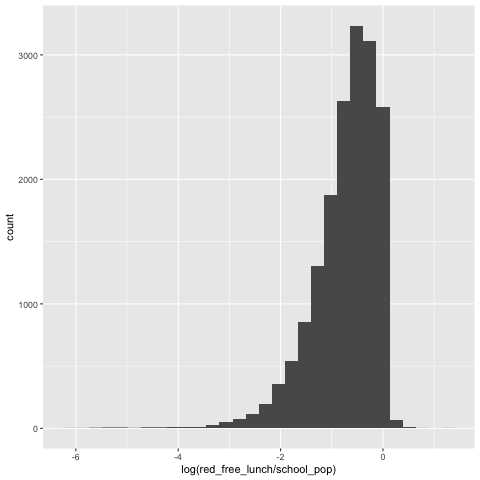

In [156]:
%%R

df_filtered %>% filter(!is.na(red_free_lunch)) %>% ggplot(aes(x = (red_free_lunch / school_pop))) + geom_histogram()